In [1]:
import pandas
import numpy
from numpy import std, correlate, sqrt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

### Data

In [2]:
filepath = 'D:/DEA/OLD/Data/Original_data.txt'
data = pandas.read_csv(filepath,sep='\t')
data.rename(columns={'origi':'Id'},inplace=True)
print(data)
print(data.shape,'from 2019_05_25_Results.xlxs')
print(data.Year.unique(),'Years')
print(data.Id.nunique(),'Number of firms')
filepath = 'D:/DEA/OLD/Data/Database_secondreviewJIBS.dta' #
data1 = pandas.read_stata(filepath)
data1.rename(columns={'id':'Id','year':'Year','country':'Country'},inplace=True)
data1 = data1[['Id','Year','Country']]
data1['Year'] = pandas.to_numeric(data1.Year.astype(str).str[0:4])
print(data1.shape,'to get country')
data = pandas.merge(left=data,right=data1,how='left',on=['Year','Id'])
print(data.Country.unique())
filepath = 'D:/DEA/OLD/Data/2019_05_25_Results_updated.txt'
data2 = pandas.read_csv(filepath,sep='\t')
print(data2.shape,'correction by Elio of market commonality')
data2.rename(columns={'origi':'Id'},inplace=True)
data2 = data2[['Id','Year','Market_commonality']]
data.drop('Market_commonality',axis=1,inplace = True)
data = pandas.merge(left=data,right=data2,how='inner',on=['Year','Id'])
print(data.Non_RD_alliances.sum(),'Total number of Non-RD alliances')
print(data.RD_alliances.sum(),'Total number of RD alliances')

      Id  Year    Age  Market_commonality  Employees Total_assets  Net_sales  \
0      1  1991   89.0               0.195    88477.0    11083.000  13340.000   
1      1  1992   90.0               0.247    87015.0    11955.000  13883.000   
2      1  1993   91.0               0.213    86168.0    12197.000  14020.000   
3      1  1994   92.0               0.253    85166.0    13496.000  15079.000   
4      1  1995   93.0               0.252    70687.0    14183.000  13460.000   
...   ..   ...    ...                 ...        ...          ...        ...   
1227  56  2008  148.0                 NaN    47426.0    44031.724  22833.908   
1228  56  2009    NaN                 NaN        NaN          NaN        NaN   
1229  56  2010    NaN                 NaN        NaN          NaN        NaN   
1230  56  2011    NaN                 NaN        NaN          NaN        NaN   
1231  56  2012    NaN                 NaN        NaN          NaN        NaN   

      Human_resources_1  Human_resource

### Aspirations

In [3]:
filepath = 'D:/DEA/OLD/Data/Results_def_01_for_Elio.txt'
data3 = pandas.read_csv(filepath,sep='\t')
data3 = data3.iloc[1008:1064,[1,17]]
data3.columns = ['Id','Efficiency']
data3.Efficiency = data3.Efficiency.astype(float)
data = pandas.merge(left=data,right=data3,how='inner',on=['Id'])
filepath = 'D:/DEA/OLD/Data/2019_10_16_AGGREGATED_LAMBDAS.txt'
data4 = pandas.read_csv(filepath,sep='\t')
data4.columns = ['Id','Lambda']
data = pandas.merge(left=data,right=data4,how='inner',on=['Id'])
data['Weighted_average_efficiency'] = ((data['Lambda'] / data['Lambda'].sum()) * data.Efficiency).sum()
data['Distance'] = data.Efficiency - data['Weighted_average_efficiency']
data['PBSA'] = data.Distance
data.loc[data.Distance > 0, 'PBSA'] = 0
data['PASA'] = data.Distance
data.loc[data.Distance < 0, 'PASA'] = 0
data['Maximum'] = data.loc[data['Lambda'] > 0, 'Efficiency'].max()
data['PBSA1'] = data.Efficiency - data.Maximum
print(data.PBSA1.max())

0.0


### Attention

In [4]:
filepath = 'D:/DEA/OLD/Data/Results_def_01_for_Elio.txt'
data5 = pandas.read_csv(filepath,sep='\t')
data5 = data5.iloc[1008:1064,[1,10,11,12]]
data5.columns = ['Id','PRO_AF','GEO_AF','GRO_AF']
data = pandas.merge(left=data,right=data5,how='inner',on=['Id'])
filepath = 'D:/DEA/OLD/Count/Data/count.txt'
data6 = pandas.read_csv(filepath,sep='\t')
data6['GEO_AF1'] = 100*data6.geographic
data6['GRO_AF1'] = 100*data6.growth
data6['PRO_AF1'] = 100*data6['product']
data6 = data6[['Id','GEO_AF1','GRO_AF1','PRO_AF1']]
data = pandas.merge(left=data,right=data6,how='inner',on=['Id'])
filepath = 'D:/DEA/OLD/Count/Data/count_sim.txt'
data7 = pandas.read_csv(filepath,sep='\t')
data7['GEO_AF2'] = 100*data7.geographic
data7['GRO_AF2'] = 100*data7.growth
data7['PRO_AF2'] = 100*data7['product']
data7  = data7[['Id','GEO_AF2','GRO_AF2','PRO_AF2']]
data = pandas.merge(left=data,right=data7,how='inner',on=['Id'])

### Ambidexterity

In [5]:
print(data.Non_RD_alliances.corr(data.RD_alliances),'if positive use the combined approach by Cao et al. 2009')
data['CAA'] = data.Non_RD_alliances * data.RD_alliances

0.680854486077821 if positive use the combined approach by Cao et al. 2009


### Control variables

In [6]:
data['Size'] = numpy.log(data.Employees) 

### Correlation

In [19]:
mydata = data[['CAA','PBSA','GEO_AF','GRO_AF','PRO_AF','PASA','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
print(len(mydata),'Number of observations')
ds_mean = mydata.agg(['mean','std']).T
corr = mydata.corr()
corr = pandas.concat([ds_mean,corr], axis = 1)
corr = corr.applymap('{:.2f}'.format)
corr['statistics'] = ' '
corr.set_index('statistics',append=True,inplace=True)
print(corr)

def pearsonr_pval(x,y):
  return pearsonr(x,y)[1].round(3)
pval = mydata.corr(method=pearsonr_pval)
pval = pval.applymap('{:.3f}'.format)
pval = pval.applymap(lambda x: '(' + x + ')')
pval['statistics'] = 'p-value'
pval.set_index('statistics',append=True,inplace=True)

corr = pandas.concat([corr,pval],axis=0).sort_index(kind='merge').reindex(['CAA','PBSA','GEO_AF','GRO_AF','PRO_AF','PASA','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year'],axis=0,level=0)
filepath = 'D:/DEA/Project_DEA/Correlation.txt'
corr.to_csv(filepath,sep = '\t',header=False,index=False)
corr



1232 Number of observations
                                   mean     std    CAA   PBSA GEO_AF GRO_AF  \
                    statistics                                                
CAA                               58.07  130.95   1.00  -0.10  -0.01   0.03   
PBSA                              -0.18    0.12  -0.10   1.00   0.02  -0.09   
GEO_AF                             1.77    2.74  -0.01   0.02   1.00   0.31   
GRO_AF                             4.46    4.05   0.03  -0.09   0.31   1.00   
PRO_AF                             4.31    2.63  -0.06   0.39  -0.80  -0.45   
PASA                               0.01    0.04  -0.13   0.51   0.05   0.12   
Absorbed_slack                     1.76   34.95  -0.02   0.03   0.06  -0.01   
Unabsorbed_slack                   1.59    2.66  -0.15   0.17  -0.16  -0.06   
Absorptive_capacity                0.26    0.78  -0.06   0.09  -0.12  -0.02   
Market_commonality                 0.40    0.14   0.07  -0.12   0.04   0.07   
Size                    

mean     std      CAA     PBSA   GEO_AF  \
                    statistics                                               
CAA                               58.07  130.95     1.00    -0.10    -0.01   
                    p-value         NaN     NaN  (1.000)  (0.004)  (0.824)   
PBSA                              -0.18    0.12    -0.10     1.00     0.02   
                    p-value         NaN     NaN  (0.004)  (1.000)  (0.484)   
GEO_AF                             1.77    2.74    -0.01     0.02     1.00   
                    p-value         NaN     NaN  (0.824)  (0.484)  (1.000)   
GRO_AF                             4.46    4.05     0.03    -0.09     0.31   
                    p-value         NaN     NaN  (0.399)  (0.002)  (0.000)   
PRO_AF                             4.31    2.63    -0.06     0.39    -0.80   
                    p-value         NaN     NaN  (0.060)  (0.000)  (0.000)   
PASA                               0.01    0.04    -0.13     0.51     0.05   
                    p-value         NaN     NaN  (0.000)  (0.000)  (0.095)   
Absorbed_slack                     1.76   34.95    -0.02     0.03     0.06   
                    p-value         NaN     NaN  (0.620)  (0.388)  (0.097)   
Unabsorbed_slack                   1.59    2.66    -0.15     0.17    -0.16   
                    p-value         NaN     NaN  (0.000)  (0.000)  (0.000)   
Absorptive_capacity                0.26    0.78    -0.06     0.09    -0.12   
                    p-value         NaN     NaN  (0.056)  (0.005)  (0.000)   
Market_commonality                 0.40    0.14     0.07    -0.12     0.04   
                    p-value         NaN     NaN  (0.041)  (0.000)  (0.252)   
Size                               9.24    1.87     0.22    -0.46     0.24   
                    p-value         NaN     NaN  (0.000)  (0.000)  (0.000)   
Year                            2001.50    6.35    -0.16     0.00    -0.00   
                    p-value         NaN     NaN  (0.000)  (1.000)  (1.000)   

                                 GRO_AF   PRO_AF     PASA Absorbed_slack  \
                    statistics                                             
CAA                                0.03    -0.06    -0.13          -0.02   
                    p-value     (0.399)  (0.060)  (0.000)        (0.620)   
PBSA                              -0.09     0.39     0.51           0.03   
                    p-value     (0.002)  (0.000)  (0.000)        (0.388)   
GEO_AF                             0.31    -0.80     0.05           0.06   
                    p-value     (0.000)  (0.000)  (0.095)        (0.097)   
GRO_AF                             1.00    -0.45     0.12          -0.01   
                    p-value     (1.000)  (0.000)  (0.000)        (0.693)   
PRO_AF                            -0.45     1.00     0.35          -0.04   
                    p-value     (0.000)  (1.000)  (0.000)        (0.219)   
PASA                               0.12     0.35     1.00          -0.00   
                    p-value     (0.000)  (0.000)  (1.000)        (0.952)   
Absorbed_slack                    -0.01    -0.04    -0.00           1.00   
                    p-value     (0.693)  (0.219)  (0.952)        (1.000)   
Unabsorbed_slack                  -0.06     0.16     0.12           0.01   
                    p-value     (0.093)  (0.000)  (0.000)        (0.702)   
Absorptive_capacity               -0.02     0.13     0.19           0.01   
                    p-value     (0.508)  (0.000)  (0.000)        (0.803)   
Market_commonality                 0.07    -0.12    -0.10          -0.02   
                    p-value     (0.020)  (0.000)  (0.002)        (0.681)   
Size                               0.05    -0.33    -0.31          -0.09   
                    p-value     (0.110)  (0.000)  (0.000)        (0.017)   
Year                              -0.00    -0.00     0.00           0.06   
                    p-value     (1.000)  (1.000)  (1.000)        (0.078)   

                             

### Mediation

In [9]:
mydata = data[['Id','CAA','Non_RD_alliances','RD_alliances','GEO_AF','PRO_AF','GRO_AF','GEO_AF1','PRO_AF1','GRO_AF1','GEO_AF2','PRO_AF2','GRO_AF2','PBSA','PASA','PBSA1','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
mydata = mydata.dropna()
mydata = (mydata - mydata.min()) / (mydata.max() - mydata.min()) 
mydata = mydata.sort_values(by=['Id','Year'], axis=0, ascending=True)
mediator_model = sm.OLS.from_formula('PRO_AF~PBSA', data=mydata)
outcome_model = sm.OLS.from_formula('CAA~PBSA+GEO_AF+GRO_AF+PRO_AF+PASA+Absorbed_slack+Unabsorbed_slack+Absorptive_capacity+Market_commonality+Size+Year', data=mydata)             
effects = Mediation(outcome_model,mediator_model,"PBSA","PRO_AF").fit(n_rep=500)
print(effects.summary())
mediator = mediator_model.fit(cov_type='HC1')
print(mediator.summary())
outcome = outcome_model.fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']})
print(outcome.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.069280       -0.114193       -0.032990    0.000
ACME (treated)           -0.069280       -0.114193       -0.032990    0.000
ADE (control)             0.075796        0.039498        0.111918    0.000
ADE (treated)             0.075796        0.039498        0.111918    0.000
Total effect              0.006516       -0.040384        0.045584    0.716
Prop. mediated (control) -1.850185      -62.451786       24.722112    0.716
Prop. mediated (treated) -1.850185      -62.451786       24.722112    0.716
ACME (average)           -0.069280       -0.114193       -0.032990    0.000
ADE (average)             0.075796        0.039498        0.111918    0.000
Prop. mediated (average) -1.850185      -62.451786       24.722112    0.716
                            OLS Regression Results                            
Dep. Variable:                 PRO_AF   R-squared:                       0.078
Model:

### Supplemental analysis

In [10]:
mydata = data[['Id','CAA','Non_RD_alliances','RD_alliances','GEO_AF','PRO_AF','GRO_AF','GEO_AF1','PRO_AF1','GRO_AF1','GEO_AF2','PRO_AF2','GRO_AF2','PBSA','PASA','PBSA1','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
mydata = mydata.dropna()
mydata = (mydata - mydata.min()) / (mydata.max() - mydata.min()) 
mydata = mydata.sort_values(by=['Id','Year'], axis=0, ascending=True)
mediator_model = sm.OLS.from_formula('PRO_AF~PBSA1', data=mydata)
outcome_model = sm.OLS.from_formula('CAA~PBSA1+GEO_AF+GRO_AF+PRO_AF+Absorbed_slack+Unabsorbed_slack+Absorptive_capacity+Market_commonality+Size+Year', data=mydata)             
effects = Mediation(outcome_model,mediator_model,"PBSA1","PRO_AF").fit(n_rep=500)
print(effects.summary())
mediator = mediator_model.fit(cov_type='HC1')
print(mediator.summary())
outcome = outcome_model.fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']})
print(outcome.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.076148       -0.122520       -0.036083    0.000
ACME (treated)           -0.076148       -0.122520       -0.036083    0.000
ADE (control)             0.107348        0.054408        0.164024    0.000
ADE (treated)             0.107348        0.054408        0.164024    0.000
Total effect              0.031201       -0.014408        0.075942    0.184
Prop. mediated (control) -1.982437      -33.086479       15.647162    0.184
Prop. mediated (treated) -1.982437      -33.086479       15.647162    0.184
ACME (average)           -0.076148       -0.122520       -0.036083    0.000
ADE (average)             0.107348        0.054408        0.164024    0.000
Prop. mediated (average) -1.982437      -33.086479       15.647162    0.184
                            OLS Regression Results                            
Dep. Variable:                 PRO_AF   R-squared:                       0.097
Model:

In [11]:
mydata = data[['Id','CAA','Non_RD_alliances','RD_alliances','GEO_AF','PRO_AF','GRO_AF','GEO_AF1','PRO_AF1','GRO_AF1','GEO_AF2','PRO_AF2','GRO_AF2','PBSA','PASA','PBSA1','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
mydata = mydata.dropna()
mydata = (mydata - mydata.min()) / (mydata.max() - mydata.min()) 
mydata = mydata.sort_values(by=['Id','Year'], axis=0, ascending=True)
mediator_model = sm.OLS.from_formula('PRO_AF~PBSA', data=mydata)
outcome_model = sm.OLS.from_formula('Non_RD_alliances~PBSA+GEO_AF+GRO_AF+PRO_AF+PASA+Absorbed_slack+Unabsorbed_slack+Absorptive_capacity+Market_commonality+Size+Year', data=mydata)             
effects = Mediation(outcome_model,mediator_model,"PBSA","PRO_AF").fit(n_rep=500)
print(effects.summary())
mediator = mediator_model.fit(cov_type='HC1')
print(mediator.summary())
outcome = outcome_model.fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']})
print(outcome.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.132073       -0.201767       -0.073514    0.000
ACME (treated)           -0.132073       -0.201767       -0.073514    0.000
ADE (control)             0.124413        0.071791        0.178700    0.000
ADE (treated)             0.124413        0.071791        0.178700    0.000
Total effect             -0.007660       -0.076757        0.059012    0.844
Prop. mediated (control)  2.910660      -54.004159       50.004414    0.844
Prop. mediated (treated)  2.910660      -54.004159       50.004414    0.844
ACME (average)           -0.132073       -0.201767       -0.073514    0.000
ADE (average)             0.124413        0.071791        0.178700    0.000
Prop. mediated (average)  2.910660      -54.004159       50.004414    0.844
                            OLS Regression Results                            
Dep. Variable:                 PRO_AF   R-squared:                       0.078
Model:

In [12]:
mydata = data[['Id','CAA','Non_RD_alliances','RD_alliances','GEO_AF','PRO_AF','GRO_AF','GEO_AF1','PRO_AF1','GRO_AF1','GEO_AF2','PRO_AF2','GRO_AF2','PBSA','PASA','PBSA1','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
mydata = mydata.dropna()
mydata = (mydata - mydata.min()) / (mydata.max() - mydata.min()) 
mydata = mydata.sort_values(by=['Id','Year'], axis=0, ascending=True)
mediator_model = sm.OLS.from_formula('PRO_AF~PBSA', data=mydata)
outcome_model = sm.OLS.from_formula('RD_alliances~PBSA+GEO_AF+GRO_AF+PRO_AF+PASA+Absorbed_slack+Unabsorbed_slack+Absorptive_capacity+Market_commonality+Size+Year', data=mydata)             
effects = Mediation(outcome_model,mediator_model,"PBSA","PRO_AF").fit(n_rep=500)
print(effects.summary())
mediator = mediator_model.fit(cov_type='HC1')
print(mediator.summary())
outcome = outcome_model.fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']})
print(outcome.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.234353       -0.328532       -0.144424    0.000
ACME (treated)           -0.234353       -0.328532       -0.144424    0.000
ADE (control)             0.193750        0.133079        0.254168    0.000
ADE (treated)             0.193750        0.133079        0.254168    0.000
Total effect             -0.040603       -0.137698        0.061436    0.436
Prop. mediated (control)  3.652701      -46.018404       41.702352    0.436
Prop. mediated (treated)  3.652701      -46.018404       41.702352    0.436
ACME (average)           -0.234353       -0.328532       -0.144424    0.000
ADE (average)             0.193750        0.133079        0.254168    0.000
Prop. mediated (average)  3.652701      -46.018404       41.702352    0.436
                            OLS Regression Results                            
Dep. Variable:                 PRO_AF   R-squared:                       0.078
Model:

### Sensitivity analysis

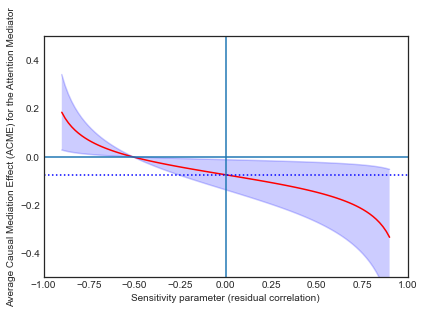

In [15]:
mydata = data[['Id','CAA','Non_RD_alliances','RD_alliances','GEO_AF','PRO_AF','GRO_AF','GEO_AF1','PRO_AF1','GRO_AF1','GEO_AF2','PRO_AF2','GRO_AF2','PBSA','PASA','PBSA1','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]
mydata = mydata.dropna()
mydata = (mydata - mydata.min()) / (mydata.max() - mydata.min()) 
mydata = mydata.sort_values(by=['Id','Year'], axis=0, ascending=True)
mydata['Intercept'] = 1
e1 = sm.OLS(mydata.PRO_AF, mydata[['Intercept','PBSA']]).fit(cov_type='HC1').resid
e2 = sm.OLS(mydata.CAA, mydata[['Intercept','PBSA','GEO_AF','GRO_AF','PASA','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]).fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']}).resid
b2 = sm.OLS(mydata.CAA, mydata[['Intercept','PBSA','GEO_AF','GRO_AF','PASA','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]).fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']}).params[1]
v = sm.OLS(mydata.CAA, mydata[['Intercept','PBSA','GEO_AF','GRO_AF','PASA','Absorbed_slack','Unabsorbed_slack','Absorptive_capacity','Market_commonality','Size','Year']]).fit(cov_type='hac-panel', cov_kwds={'maxlags':1, 'groups':mydata['Id']}).bse[1]
s1 = std(e1)
s2 = std(e2)
r = correlate(e1,e2)
x = numpy.linspace(-0.9,0.9,100)
ACME = b2*(s1/s2)*(r-x*sqrt((1-r*r)/(1-x*x)))
SE = (v)*(s1/s2)*(r-x*sqrt((1-r*r)/(1-x*x)))
h = ACME + 1.645*SE
l = ACME - 1.645*SE
fig = plt.figure()
plt.fill_between(x,h,l,facecolor='blue',alpha=0.2)
ACME = plt.plot(x,ACME, 'r')
h = plt.plot(x,h, 'b',alpha=0.2)
l = plt.plot(x,l, 'b',alpha=0.2)
plt.ylabel('Average Causal Mediation Effect (ACME) for the Attention Mediator')
plt.xlabel('Sensitivity parameter (residual correlation)')
plt.axvline(0)
plt.axhline(0)
plt.axhline(y=-0.075, color='b', linestyle='dotted')
plt.axis((-1,1,-0.5,0.5))
fig.tight_layout()
plt.show()